# Notebook 2: Enhancing Images with Stable Diffusion Img2Img Pipeline


### 1. Install Required Libraries

In [2]:
# Run this cell to install necessary packages
!pip install --upgrade diffusers transformers torch torchvision ipywidgets
!pip install opencv-python matplotlib

#### 3.1 Optional: Install `accelerate` for faster and less memory-intense model loading.

In [3]:
!pip install accelerate

### 2. Import Libraries

In [4]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
### 3. Load Models

In [6]:
# Load the Stable Diffusion img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/jeremy/Documents/diffusion-playground/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Enable GPU acceleration
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [8]:
# Use an efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 4. Prepare Input Image

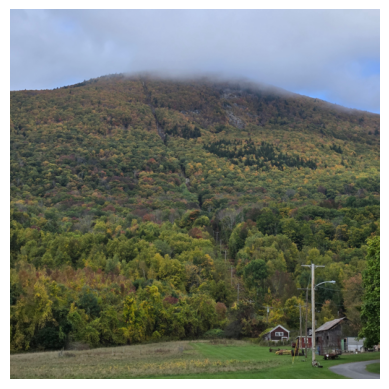

In [16]:
# Load the input image
input_image = Image.open("test-images/20240929_102048-EDIT.jpg").convert("RGB")
input_image = input_image.resize((512, 512))

plt.imshow(input_image)
plt.axis('off')  # Hide the axes
plt.show()

### 5. Define Parameters

In [17]:
# Set the denoising strength (lower value = closer to input, higher value = more artistic freedom)
denoising_strength = 0.5

# Set the number of sampling steps
num_inference_steps = 50

prompt = ""
negative_prompt = "low quality, blurry, deformed, bad anatomy"
guidance_scale = 7.5

### 6. Generate the Enhanced Image

In [19]:
# Generate the enhanced image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        strength=denoising_strength,
    )

enhanced_image = output.images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

### 7. Display and Save the Results

In [20]:
# Save the enhanced image
enhanced_image.save("output-images/enhanced_img2img.jpg")

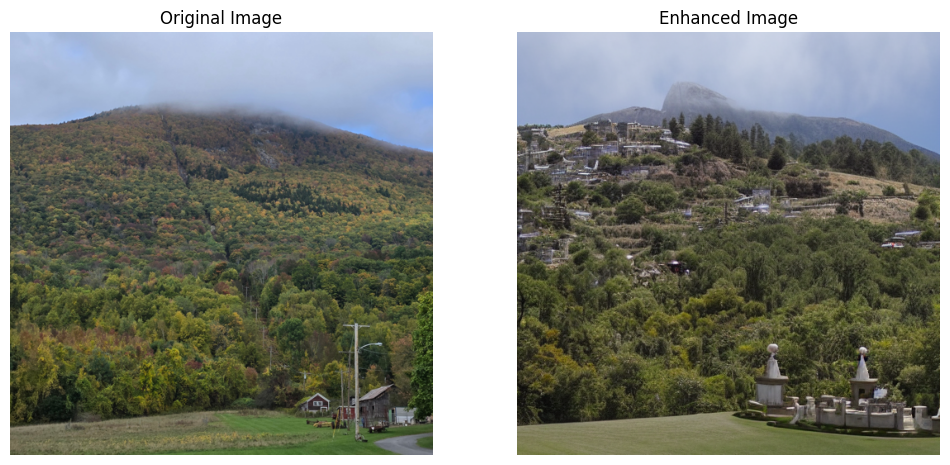

In [21]:
# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(enhanced_image)
ax[1].set_title("Enhanced Image")
ax[1].axis("off")

plt.show()

### 8. Style Transfer
By using a higher denoising strength in conjunction with a prompt, you can create a style transfer effect.

In [22]:
# Define the style transfer prompt
prompt = "A painting in the style of Vincent van Gogh"

# Set the denoising strength (controls the level of transformation)
denoising_strength = 0.8  # Higher value for more stylistic changes

In [24]:
# Generate the style-transferred image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        strength=denoising_strength,
    )

styled_image = output.images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

### 9. Display and Save the Style-Transferred Image

In [25]:
# Save the style-transferred image
styled_image.save("output-images/styled_img2img.jpg")

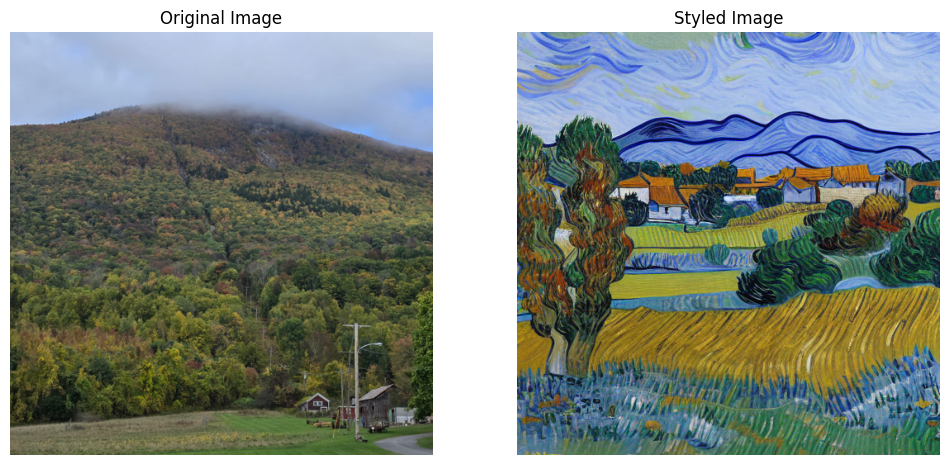

In [26]:
# Display the original and styled images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(styled_image)
ax[1].set_title("Styled Image")
ax[1].axis("off")

plt.show()